712_Xiaomi

Degenerate mixture covariance


Transition matrix (7x7):
[[0.078 0.048 0.    0.    0.    0.001 0.873]
 [0.    0.    0.128 0.872 0.    0.    0.   ]
 [0.    0.001 0.    0.811 0.188 0.    0.   ]
 [0.    0.    0.946 0.    0.    0.    0.054]
 [0.    0.783 0.003 0.    0.    0.    0.214]
 [1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.002 0.    0.    0.    0.826 0.172]]

Mixture means for feature = LogReturn (original units):
State 0: mix0=+0.011239, mix1=-0.013912
State 1: mix0=+0.036858, mix1=+0.007259
State 2: mix0=-0.008594, mix1=+0.024213
State 3: mix0=-0.008890, mix1=-0.230524
State 4: mix0=+0.051540, mix1=+0.127334
State 5: mix0=-0.007773, mix1=+0.001120
State 6: mix0=-0.001878, mix1=+0.006965

Time share per Regime (%):
Regime
0    21.79
1     2.61
2    14.06
3    14.06
4     2.61
5    21.79
6    23.07
Name: proportion, dtype: float64


C:\Users\Dell\AppData\Local\Temp\ipykernel_4600\1129922007.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_scaled = float(model.means_[s][m])
C:\Users\Dell\AppData\Local\Temp\ipykernel_4600\1129922007.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_scaled = float(model.means_[s][m])
C:\Users\Dell\AppData\Local\Temp\ipykernel_4600\1129922007.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_scaled = float(model.means_[s][m])
C:\Users\Dell\AppDa

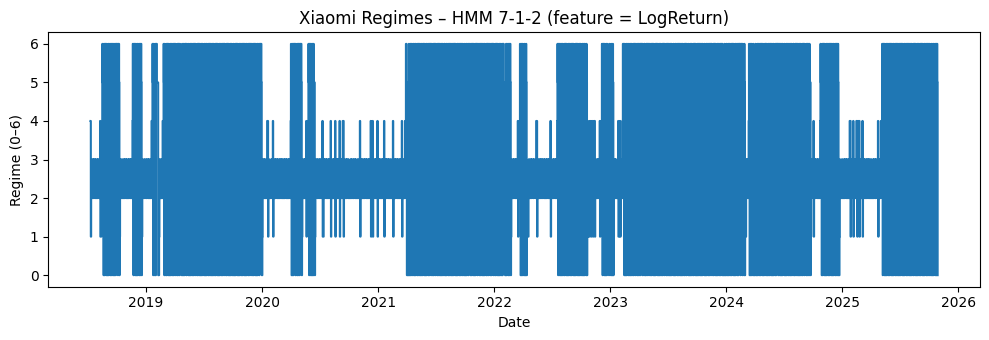

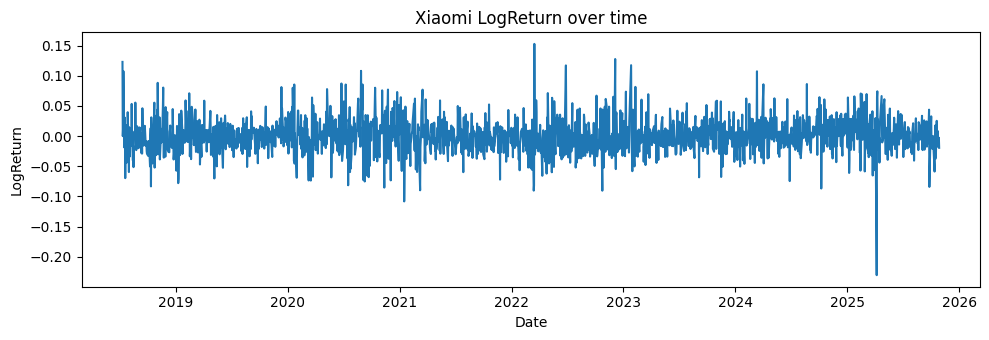

In [1]:
# Thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GMMHMM
from sklearn.preprocessing import StandardScaler
import os

# Load data
df = pd.read_csv(r'Xiaomi_clean.csv')
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

date_col = 'Date' if 'Date' in df.columns else [c for c in df.columns if 'date' in c.lower()][0]
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)

close_candidates = ['Adj_Close','AdjClose','Close','close','Price','price']
close_col = None
for c in df.columns:
    if c in close_candidates or c.lower() in ['close','adj close','adj_close','price']:
        close_col = c; break
if close_col is None:
    close_col = df.select_dtypes(include=[np.number]).columns[0]

# Tạo LogReturn + Volatility
df['LogReturn'] = np.log(df[close_col]).diff()
df['Volatility'] = df['LogReturn'].rolling(20).std() * np.sqrt(252)
df = df.dropna(subset=['LogReturn']).reset_index(drop=True)
df.rename(columns={date_col: 'Date'}, inplace=True)

# ==== CHỌN 1 FEATURE ====
feature_name = 'LogReturn'         

X_raw = df[[feature_name]].values
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
lengths = [len(X)]

# HMM 7:1:2
model = GMMHMM(
    n_components=7,
    n_mix=2,
    covariance_type='diag',
    n_iter=300, tol=1e-3,
    random_state=42, verbose=False
)
model.fit(X, lengths)
df['Regime'] = model.predict(X)

# Phân tích
print("Transition matrix (7x7):")
print(np.round(model.transmat_, 3))

print(f"\nMixture means for feature = {feature_name} (original units):")
for s in range(model.n_components):
    vals = []
    for m in range(model.n_mix):
        mu_scaled = float(model.means_[s][m])
        mu_orig = scaler.inverse_transform([[mu_scaled]])[0,0]
        vals.append(mu_orig)
    print(f"State {s}: mix0={vals[0]:+.6f}, mix1={vals[1]:+.6f}")

share = (df['Regime'].value_counts(normalize=True).sort_index()*100).round(2)
print("\nTime share per Regime (%):")
print(share)

#Vẽ biểu đồ
plt.figure(figsize=(10,3.5))
plt.plot(df['Date'], df['Regime'], drawstyle='steps-post')
plt.title(f'Xiaomi Regimes – HMM 7-1-2 (feature = {feature_name})')
plt.xlabel('Date'); plt.ylabel('Regime (0–6)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3.5))
plt.plot(df['Date'], df[feature_name])
plt.title(f'Xiaomi {feature_name} over time')
plt.xlabel('Date'); plt.ylabel(feature_name)
plt.tight_layout(); plt.show()

out_path = os.path.join(os.path.dirname(r'Xiaomi_clean.csv'), f'xiaomi_hmm712_{feature_name.lower()}_regimes.csv')
df.to_csv(out_path, index=False)
